In [2]:
!pip install einops

  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
Using cached einops-0.8.0-py3-none-any.whl (43 kB)


In [3]:
import argparse
import h5py
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import cv2

from dataset import EmbeddingDataset
from transformer import Transformer

In [4]:
def attention_rollout(attentions, discard_ratio=0.9):
    result = torch.eye(attentions[0].size(-1)).to(attentions[0].device)
    with torch.no_grad():
        for attention in attentions:
            # Average attention weights across all heads
            attention_heads_fused = attention.mean(axis=1)
            # Drop a certain ratio of the lowest attention weights
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim=-1, largest=False)
            mask = torch.ones_like(flat, dtype=torch.bool)
            mask.scatter_(1, indices, False)
            mask = mask.view_as(attention_heads_fused)
            attention_heads_fused[mask] = 0

            I = torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device)
            a = (attention_heads_fused + 1.0 * I) / 2
            result = torch.matmul(a, result)

    return result


def visualize_attention_map(attention_map, image, save_path):
    attention_map = attention_map.detach().cpu().numpy()
    attention_map = np.mean(attention_map, axis=0)
    attention_map = attention_map / attention_map.max()
    attention_map = cv2.resize(attention_map, (image.shape[1], image.shape[0]))

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(attention_map, cmap='jet', alpha=0.5) # attention map을 overlay합니다.
    plt.axis('off')
    plt.savefig(save_path)
    # plt.show()

In [7]:
data_df = pd.read_csv('/data2/jiwon/TCGA_STAD/her2_class_512_test.csv')
dir_path = '/data2/jiwon/TCGA_STAD/CTransPath_feat_test'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset
train_dataset = EmbeddingDataset(dir_path, data_df, train=True)
val_dataset = EmbeddingDataset(dir_path, data_df, train=False)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
print('# of train dataset:', len(train_dataset), '# of test dataset', len(val_loader))

# of train dataset: 112 # of test dataset 28


In [16]:
# 모델 로드 및 데이터 준비
model = Transformer(input_dim=768, num_classes=2)
model.load_state_dict(torch.load('C:/Users/heeryung/code/HistoBistrockpt_100.pth'))
model.eval()

# 입력 데이터 준비
# inputs = torch.rand(1, 1, 2048)  # 예시 입력 데이터

for i, (inputs, labels) in enumerate(val_loader): 
    outputs = model(inputs, register_hook=True)

    # attention map 추출
    attention_maps = model.get_attention_maps()

    # attention rollout 수행
    rollout_map = attention_rollout(attention_maps)

    # 시각화를 위한 이미지 준비 (여기서는 예시로 랜덤 이미지 사용)
    image = np.random.rand(224, 224, 3)

    # attention map 시각화
    visualize_attention_map(rollout_map, image, f'/data2/jiwon/CPath/Custom_HistoBistro/trial2/attention_map_{i}.png')

KeyboardInterrupt: 

In [13]:
attention_maps = model.get_attention_maps()

for idx, att_map in enumerate(attention_maps):
    print(f"Attention Map {idx}: Shape: {att_map.shape}, Min: {att_map.min().item()}, Max: {att_map.max().item()}")

Attention Map 0: Shape: torch.Size([1, 8, 902, 902]), Min: 0.0, Max: 1.0
Attention Map 1: Shape: torch.Size([1, 8, 902, 902]), Min: 0.0, Max: 1.0


In [5]:
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

In [6]:
def generate_rollout(model, input, start_layer=0):
    model(input)
    blocks = model.transformer.layers
    all_layer_attentions = []
    for blk in blocks:
        attn_heads = blk[0].fn.get_attention_map()
        avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
        all_layer_attentions.append(avg_heads)
    rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
    return rollout[:,0, 1:]

In [18]:
def NormalizeData(data):
    return (data - data.min()) / (data.max() - data.min())

def plot_scores(scores, image, overlay=True, clamp=0.05, norm=True, colormap='RdBu', crop=False, indices=[]):
    if clamp:
        q05, q95 = torch.quantile(scores, clamp), torch.quantile(scores, 1-clamp)
        scores.clamp_(q05,q95)
    
    if norm:
        scores = NormalizeData(scores)
        
    y_min, y_max, x_min, x_max = 0, image.shape[0], 0, image.shape[1]
        
    attention_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
    tissue_map = -np.ones((image.shape[0], image.shape[1]), dtype=np.float32)
    
    for i, s in enumerate(scores):
        x, y = (i % image.shape[1]), (i // image.shape[1])
        
        if colormap == 'RdBu': 
            attention_map[y, x] = 1 - s.item()
        else: 
            attention_map[y, x] = s.item()
        tissue_map[y, x] = s.item()
       
    attention_map = np.array(attention_map * 255., dtype=np.uint8)
    tissue_map[tissue_map>=0] = 1
    tissue_map[tissue_map<0] = 0

    if len(indices) != 0:
        highlight_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
        for i in indices:
            x, y = (i % image.shape[1]), (i // image.shape[1])
            highlight_map[y, x] = 1    
                 
    a = 1.
    if overlay:
        plt.imshow(image[y_min:y_max, x_min:x_max])
        a = 0.5
    
    if crop:
        plt.imshow(attention_map[y_min:y_max, x_min:x_max], alpha=a*(tissue_map[y_min:y_max, x_min:x_max]), cmap=colormap, interpolation='nearest')
    else:
        plt.imshow(attention_map, alpha=a*(tissue_map), cmap=colormap, interpolation='nearest')
    
    if len(indices) != 0:
        plt.imshow(highlight_map[y_min:y_max, x_min:x_max], alpha=1.*(highlight_map), cmap='viridis', interpolation='nearest')
    
    plt.axis('off')

In [11]:
OPENSLIDE_PATH = r'C:\Users\heeryung\anaconda3\envs\jiwon2\Lib\site-packages\openslide-bin-4.0.0.3-windows-x64\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [27]:
feature_path = 'D:/TCGA_STAD/CTransPath_feat_test/3dc00b29-2e7e-4cff-b81f-2c75e7a7bae1.h5'
slide_path = 'D:/TCGA_STAD/TCGA_STAD/3dc00b29-2e7e-4cff-b81f-2c75e7a7bae1/TCGA-BR-A4PE-01Z-00-DX1.9C427636-8A7E-4D4E-9773-5C5D9D0C617C.svs'

h5_file = h5py.File(feature_path)
features = torch.Tensor(np.array(h5_file['features'])).unsqueeze(0)
# coords = torch.Tensor(np.array(h5_file['coords']))
# coords = [(coords[i, 0].int().item(), coords[i, 1].int().item()) for i in range(coords.shape[0])]

slide = openslide.open_slide(slide_path)
level = len(slide.level_downsamples) - 1
d = slide.level_downsamples[level]
image = slide.read_region((0,0), level, slide.level_dimensions[level])

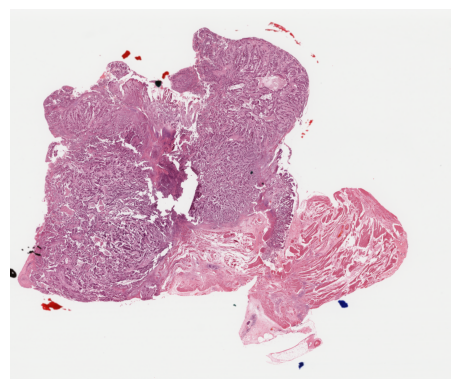

In [23]:
# 모델 로드 및 데이터 준비
model = Transformer(input_dim=768, num_classes=2)
model.load_state_dict(torch.load('C:/Users/heeryung/code/HistoBistro/ckpt_100.pth'))
model.eval()

rollout = generate_rollout(model, features, start_layer=0).squeeze(0)

image = np.array(image)
plot_scores(rollout, image, overlay=True, colormap='viridis', crop=False)
plt.show()


In [24]:
image.shape

(2671, 3183, 4)

In [ ]:
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

def generate_rollout(model, input, start_layer=0):
    model(input)
    blocks = model.transformer.layers
    all_layer_attentions = []
    for blk in blocks:
        attn_heads = blk[0].fn.get_attention_map()
        avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
        all_layer_attentions.append(avg_heads)
    rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
    return rollout[:,0, 1:]

def NormalizeData(data):
    return (data - data.min()) / (data.max() - data.min())

def plot_scores(scores, image, overlay=True, clamp=0.05, norm=True, colormap='RdBu', crop=False, indices=[]):
    if clamp:
        q05, q95 = torch.quantile(scores, clamp), torch.quantile(scores, 1-clamp)
        scores.clamp_(q05,q95)
    
    if norm:
        scores = NormalizeData(scores)
        
    y_min, y_max, x_min, x_max = 0, image.shape[0], 0, image.shape[1]
        
    attention_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
    tissue_map = -np.ones((image.shape[0], image.shape[1]), dtype=np.float32)
    
    for i, s in enumerate(scores):
        x, y = (i % image.shape[1]), (i // image.shape[1])
        
        if colormap == 'RdBu': 
            attention_map[y, x] = 1 - s.item()
        else: 
            attention_map[y, x] = s.item()
        tissue_map[y, x] = s.item()
       
    attention_map = np.array(attention_map * 255., dtype=np.uint8)
    tissue_map[tissue_map>=0] = 1
    tissue_map[tissue_map<0] = 0

    if len(indices) != 0:
        highlight_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
        for i in indices:
            x, y = (i % image.shape[1]), (i // image.shape[1])
            highlight_map[y, x] = 1    
                 
    a = 1.
    if overlay:
        plt.imshow(image[y_min:y_max, x_min:x_max])
        a = 0.5
    
    if crop:
        plt.imshow(attention_map[y_min:y_max, x_min:x_max], alpha=a*(tissue_map[y_min:y_max, x_min:x_max]), cmap=colormap, interpolation='nearest')
    else:
        plt.imshow(attention_map, alpha=a*(tissue_map), cmap=colormap, interpolation='nearest')
    
    if len(indices) != 0:
        plt.imshow(highlight_map[y_min:y_max, x_min:x_max], alpha=1.*(highlight_map), cmap='viridis', interpolation='nearest')
    
    plt.axis('off')

h5_file = h5py.File(feature_path)
features = torch.Tensor(np.array(h5_file['features'])).unsqueeze(0)
# coords = torch.Tensor(np.array(h5_file['coords']))
# coords = [(coords[i, 0].int().item(), coords[i, 1].int().item()) for i in range(coords.shape[0])]

slide = openslide.open_slide(slide_path)
level = len(slide.level_downsamples) - 1
d = slide.level_downsamples[level]
image = slide.read_region((0,0), level, slide.level_dimensions[level])

# 모델 로드 및 데이터 준비
model = Transformer(input_dim=768, num_classes=2)
model.load_state_dict(torch.load('C:/Users/heeryung/code/HistoBistro/ckpt_100.pth'))
model.eval()

rollout = generate_rollout(model, features, start_layer=0).squeeze(0)

image = np.array(image)
plot_scores(rollout, image, overlay=True, colormap='viridis', crop=False)
plt.show()


In [33]:
from scipy.ndimage import zoom

def compute_rollout_attention(all_layer_matrices, start_layer=0):
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

def generate_rollout(model, input, start_layer=0):
    model(input)
    blocks = model.transformer.layers
    all_layer_attentions = []
    for blk in blocks:
        attn_heads = blk[0].fn.get_attention_map()
        avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
        all_layer_attentions.append(avg_heads)
    rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
    return rollout[:,0, 1:]

def NormalizeData(data):
    return (data - data.min()) / (data.max() - data.min())

def plot_scores(scores, image, overlay=True, clamp=0.05, norm=True, colormap='RdBu', crop=False, indices=[]):
    if clamp:
        q05, q95 = torch.quantile(scores, clamp), torch.quantile(scores, 1-clamp)
        scores.clamp_(q05, q95)
    
    if norm:
        scores = NormalizeData(scores)
        
    y_min, y_max, x_min, x_max = 0, image.shape[0], 0, image.shape[1]
        
    attention_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
    tissue_map = -np.ones((image.shape[0], image.shape[1]), dtype=np.float32)
    
    # scores 텐서의 크기를 이미지 크기에 맞게 조정
    scores_resized = zoom(scores.detach().cpu().numpy().reshape(1, -1), (1, image.shape[0] * image.shape[1] / scores.shape[0]))[0].reshape(image.shape[0], image.shape[1])

    if colormap == 'RdBu':
        attention_map = 1 - scores_resized
    else:
        attention_map = scores_resized

    attention_map = np.array(attention_map * 255., dtype=np.uint8)
    tissue_map = (scores_resized >= 0).astype(np.float32)

    if len(indices) != 0:
        highlight_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
        for i in indices:
            x, y = (i % image.shape[1]), (i // image.shape[1])
            highlight_map[y, x] = 1    
                 
    a = 1.
    if overlay:
        plt.imshow(image[y_min:y_max, x_min:x_max])
        a = 0.5
    
    if crop:
        plt.imshow(attention_map[y_min:y_max, x_min:x_max], alpha=a * (tissue_map[y_min:y_max, x_min:x_max]), cmap=colormap, interpolation='nearest')
    else:
        plt.imshow(attention_map, alpha=a * tissue_map, cmap=colormap, interpolation='nearest')
    
    if len(indices) != 0:
        plt.imshow(highlight_map[y_min:y_max, x_min:x_max], alpha=1. * highlight_map, cmap='viridis', interpolation='nearest')
    
    plt.axis('off')
    plt.show()

# h5_file = h5py.File('path_to_your_feature_file.h5')
h5_file = h5py.File(feature_path)
features = torch.Tensor(np.array(h5_file['features'])).unsqueeze(0)

# slide_path = 'path_to_your_slide_file.svs'
slide = openslide.open_slide(slide_path)
level = len(slide.level_downsamples) - 1
d = slide.level_downsamples[level]
image = slide.read_region((0, 0), level, slide.level_dimensions[level])

In [36]:
image = image.convert("RGB")

# 이미지 (224, 224) 크기로 리사이즈
image = image.resize((224, 224))

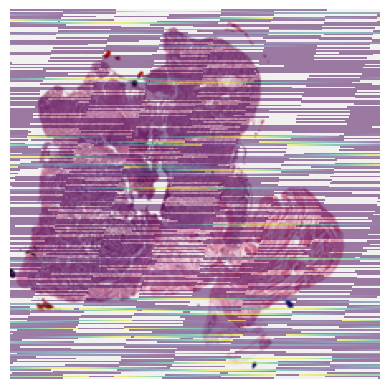

In [38]:

# 모델 로드 및 데이터 준비
model = Transformer(input_dim=768, num_classes=2)
model.load_state_dict(torch.load('C:/Users/heeryung/code/HistoBistro/ckpt_100.pth'))
model.eval()

rollout = generate_rollout(model, features, start_layer=0).squeeze(0)

image = np.array(image)
plot_scores(rollout, image, overlay=True, colormap='viridis', crop=False)
plt.show()

In [40]:
rollout.shape

torch.Size([786])

In [42]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import h5py
import openslide
import torch.nn.functional as F

def compute_rollout_attention(all_layer_matrices, start_layer=0):
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

def generate_rollout(model, input, start_layer=0):
    model(input)
    blocks = model.transformer.layers
    all_layer_attentions = []
    for blk in blocks:
        attn_heads = blk[0].fn.get_attention_map()
        avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
        all_layer_attentions.append(avg_heads)
    rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
    return rollout[:,0, 1:]

def NormalizeData(data):
    return (data - data.min()) / (data.max() - data.min())

def plot_scores(scores, image, overlay=True, clamp=0.05, norm=True, colormap='RdBu', crop=False, indices=[]):
    if clamp:
        q05, q95 = torch.quantile(scores, clamp), torch.quantile(scores, 1-clamp)
        scores.clamp_(q05, q95)
    
    if norm:
        scores = NormalizeData(scores)
        
    y_min, y_max, x_min, x_max = 0, image.shape[0], 0, image.shape[1]
        
    attention_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
    tissue_map = -np.ones((image.shape[0], image.shape[1]), dtype=np.float32)
    
    # scores 텐서의 크기를 이미지 크기에 맞게 조정
    scores = scores.view(1, 1, int(np.sqrt(scores.shape[0])), int(np.sqrt(scores.shape[0])))
    scores_resized = F.interpolate(scores, size=(image.shape[0], image.shape[1]), mode='bilinear').squeeze().numpy()

    if colormap == 'RdBu':
        attention_map = 1 - scores_resized
    else:
        attention_map = scores_resized

    attention_map = np.array(attention_map * 255., dtype=np.uint8)
    tissue_map = (scores_resized >= 0).astype(np.float32)

    if len(indices) != 0:
        highlight_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
        for i in indices:
            x, y = (i % image.shape[1]), (i // image.shape[1])
            highlight_map[y, x] = 1    
                 
    a = 1.
    if overlay:
        plt.imshow(image[y_min:y_max, x_min:x_max])
        a = 0.5
    
    if crop:
        plt.imshow(attention_map[y_min:y_max, x_min:x_max], alpha=a * (tissue_map[y_min:y_max, x_min:x_max]), cmap=colormap, interpolation='nearest')
    else:
        plt.imshow(attention_map, alpha=a * tissue_map, cmap=colormap, interpolation='nearest')
    
    if len(indices) != 0:
        plt.imshow(highlight_map[y_min:y_max, x_min:x_max], alpha=1. * highlight_map, cmap='viridis', interpolation='nearest')
    
    plt.axis('off')
    plt.show()

# h5_file = h5py.File('path_to_your_feature_file.h5')
h5_file = h5py.File(feature_path)
features = torch.Tensor(np.array(h5_file['features'])).unsqueeze(0)

# slide_path = '/mnt/data/your_slide_file.svs'
slide = openslide.open_slide(slide_path)
level = len(slide.level_downsamples) - 1
d = slide.level_downsamples[level]
image = slide.read_region((0, 0), level, slide.level_dimensions[level])

# 모델 로드 및 데이터 준비
model = Transformer(input_dim=768, num_classes=2)
model.load_state_dict(torch.load('C:/Users/heeryung/code/HistoBistro/ckpt_100.pth'))
model.eval()

rollout = generate_rollout(model, features, start_layer=0).squeeze(0)

image = np.array(image)
plot_scores(rollout, image, overlay=True, colormap='viridis', crop=False)
plt.show()


RuntimeError: shape '[1, 1, 28, 28]' is invalid for input of size 786

# Visualization

In [123]:
feature_path = 'D:/TCGA_STAD/CTransPath_feat_test/07dce26b-06d2-4c83-85fc-7084e3263bdc.h5'
slide_path = 'D:/TCGA_STAD/TCGA_STAD/07dce26b-06d2-4c83-85fc-7084e3263bdc/TCGA-BR-8382-01Z-00-DX1.b74fc4a1-4dfc-47dc-8ee1-2fa44ad17a69.svs'

In [135]:
feature_path = 'D:/TCGA_STAD/CTransPath_feat_test/40c3a8bb-33cd-484f-ad88-cd241e5f9bd1.h5'
slide_path = 'D:/TCGA_STAD/TCGA_STAD/40c3a8bb-33cd-484f-ad88-cd241e5f9bd1/TCGA-D7-6526-01Z-00-DX2.8846E328-5343-4A95-A77D-3827F443A989.svs'

In [136]:
model = Transformer(input_dim=768, num_classes=2)
model.load_state_dict(torch.load('C:/Users/heeryung/code/HistoBistro/ckpt_10.pth'))
model.eval()

Transformer(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
  )
  (mlp_head): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=512, out_features=2, bias=True)
  )
  (transformer): TransformerBlocks(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): GELU(approximate='none')
              

In [137]:
h5_file = h5py.File(feature_path)
features = torch.Tensor(np.array(h5_file['features'])).unsqueeze(0)
name = np.array(h5_file['filenames'])

coords = []
for item in name:
    x, y, *_ = item.decode().split('_')
    coords.append((int(x), int(y)))
coords = torch.Tensor(coords)
coords = [(coords[i, 0].int().item(), coords[i, 1].int().item()) for i in range(coords.shape[0])]

slide = openslide.open_slide(slide_path)
level = len(slide.level_downsamples) - 1
d = slide.level_downsamples[level]
image = slide.read_region((0, 0), level, slide.level_dimensions[level])
image = np.array(image.convert("RGB"))

In [138]:
# function that plots scores nicely. scores should have the same length as the number of tiles.
def NormalizeData(data):
    return (data - data.min()) / (data.max() - data.min())

def plot_scores(coords, scores, image, overlay=True, clamp=0.05, norm=True, colormap='RdBu', crop=False, indices=[]):
    if clamp:
        q05, q95 = torch.quantile(scores, clamp), torch.quantile(scores, 1-clamp)
        scores.clamp_(q05,q95)
    
    if norm:
        scores = NormalizeData(scores)
        
    if crop:
        coords_min, coords_max = np.array(coords).min(axis=0), np.array(coords).max(axis=0)
        y_min, y_max, x_min, x_max = round(coords_min[1]/d), round(coords_max[1]/d), round(coords_min[0]/d), round(coords_max[0]/d)
        # if slide_path.stem == '439042':
        #     x_max = round((69 * 1013)/d)
        # print(y_min, y_max, x_min, x_max)
    else:
        y_min, y_max, x_min, x_max = 0, image.shape[0], 0, image.shape[1]
        
        
    attention_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
    tissue_map = -np.ones((image.shape[0], image.shape[1]), dtype=np.float32)
    
    offset = 2100
    for (x,y), s in zip(coords, scores):
        
        if colormap == 'RdBu': 
            attention_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = 1 - s.item()
        else: 
            attention_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = s.item()
        tissue_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = s.item()
       
    attention_map = np.array(attention_map * 255., dtype=np.uint8)
    tissue_map[tissue_map>=0] = 1
    tissue_map[tissue_map<0] = 0

    if len(indices) != 0:
        highlight_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
        for i in indices:
            x, y = coords[i]
            highlight_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = 1    
                 
#     plt.figure(figsize=(30, 30))
    a = 1.
    if overlay:
        plt.imshow(image[y_min:y_max, x_min:x_max])
        a = 0.5
    
    if crop:
        plt.imshow(attention_map[y_min:y_max, x_min:x_max], alpha=a*(tissue_map[y_min:y_max, x_min:x_max]), cmap=colormap, interpolation='nearest')
#         plt.imshow(attention_map[round(coords_min[1]/d):, round(coords_min[0]/d):], alpha=a*(tissue_map[round(coords_min[1]/d):, round(coords_min[0]/d):]), cmap=colormap, interpolation='nearest')
    else:
        plt.imshow(attention_map, alpha=a*(tissue_map), cmap=colormap, interpolation='nearest')
    
    if len(indices) != 0:
        plt.imshow(highlight_map[y_min:y_max, x_min:x_max], alpha=1.*(highlight_map), cmap='viridis', interpolation='nearest')
    
    plt.axis('off')

In [131]:
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

def generate_rollout(model, input, start_layer=0):
    model(input)
    blocks = model.transformer.layers
    all_layer_attentions = []
    for blk in blocks:
        attn_heads = blk[0].fn.get_attention_map()
        avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
        all_layer_attentions.append(avg_heads)
    rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
    return rollout[:,0, 1:]

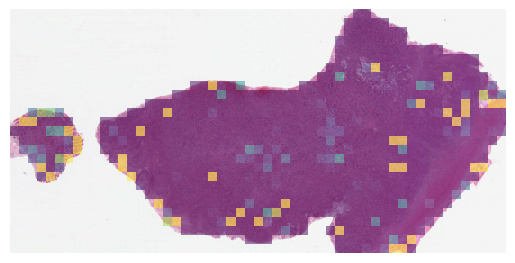

In [132]:
rollout = generate_rollout(model, features, start_layer=0).squeeze(0)
plot_scores(coords, rollout, image, overlay=True, colormap='viridis', crop=True)
plt.show()

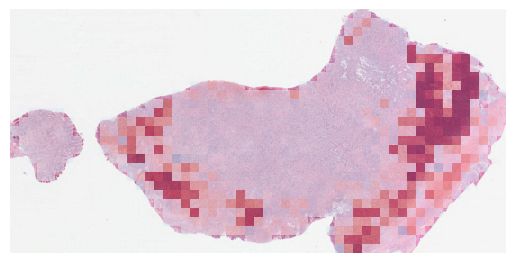

In [133]:
n = features.shape[1]
scores = np.zeros(n)

for i in range(n):
    out = model(features[:, i:i+1, :]).squeeze(0)
    # print(out)
    scores[i] = torch.sigmoid(out[0]).item()  # Use the first element of out and convert to a Python scalar

plot_scores(coords, scores, image, overlay=True, colormap='RdBu_r', clamp=False, norm=False, crop=True)
plt.show()

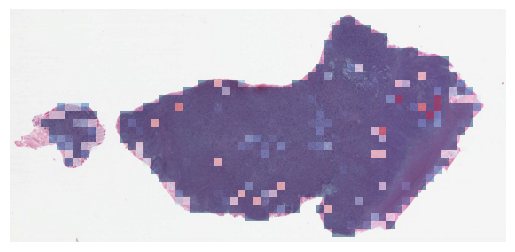

In [134]:
plot_scores(coords, rollout * scores, image, overlay=True, colormap='RdBu_r', clamp=False, norm=True)
plt.show()

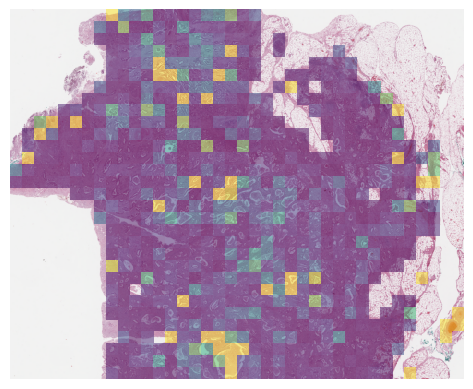

In [139]:
rollout = generate_rollout(model, features, start_layer=0).squeeze(0)
plot_scores(coords, rollout, image, overlay=True, colormap='viridis', crop=True)
plt.show()

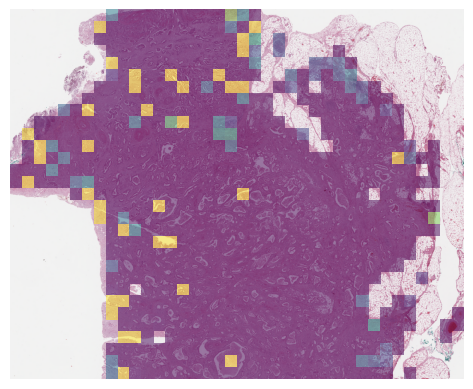

In [121]:
rollout = generate_rollout(model, features, start_layer=0).squeeze(0)
plot_scores(coords, rollout, image, overlay=True, colormap='viridis', crop=True)
plt.show()

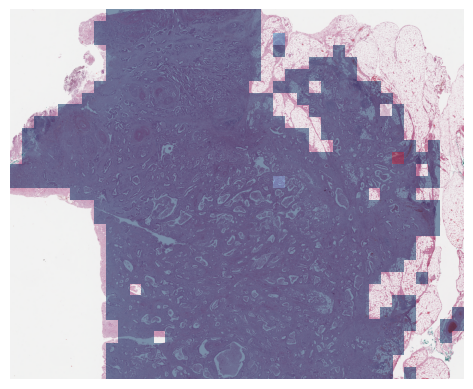

In [122]:
n = features.shape[1]
scores = np.zeros(n)

for i in range(n):
    out = model(features[:, i:i+1, :]).squeeze(0)
    # print(out)
    scores[i] = torch.sigmoid(out[0]).item()  # Use the first element of out and convert to a Python scalar

plot_scores(coords, scores, image, overlay=True, colormap='RdBu_r', clamp=False, norm=False, crop=True)
plt.show()